In [1]:
### Testing Model to Unseen Data

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

2025-04-19 19:08:59.297566: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 19:08:59.368356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-19 19:08:59.368390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-19 19:08:59.374479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-19 19:08:59.387863: I tensorflow/core/platform/cpu_feature_guar

In [3]:
hp = {
    'learning_rate' : 5e-5,
    'epochs' : 150,
    'batch_size' : 128,
    'model' : 'xlm-roberta-base',
    'exp_desc' : 'default_run'
}
randnum = 45#42
MAX_LENGTH = 150
BATCH_SIZE = 128

run_name = f"{hp['model']}__lr{hp['learning_rate']}_ep{hp['epochs']}_bs{hp['batch_size']}"
# checkpoint_filepath = f"./checkpoints/{run_name}.h5"
checkpoint_filepath = f"./checkpoints/XLM-RoBERTa__lr5e-05_ep150_bs128.h5"

In [4]:
# Model Names: 
# 'bert-base-uncased' (bert)
# 'bert-base-multilingual-cased' (mBERT)
# 'xlm-roberta-base' or "distilroberta-base" (XLM-RoBERTa, Distil Roberta)
# "google-bert/bert-base-cased" (mobileBert)

MODEL_NAME = 'xlm-roberta-base'

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [6]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    # hidden_dropout_prob=0.3,
    # attention_probs_dropout_prob=0.15
)

2025-04-19 19:09:03.426986: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-19 19:09:03.486461: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-19 19:09:03.486527: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-19 19:09:03.491817: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-19 19:09:03.491890: I external/local_xla/xla/stream_executor

In [7]:
# Load dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'label']].dropna()
    df['label'] = df['label'].astype(int)
    return df

In [8]:
# Tokenization function
def tokenize_data(texts, tokenizer):
    return tokenizer.batch_encode_plus(
        texts,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

In [9]:
# Prepare datasets
def prepare_datasets(train_df, val_df, test_df, tokenizer):
    train_encodings = tokenize_data(train_df['text'].tolist(), tokenizer)
    val_encodings = tokenize_data(val_df['text'].tolist(), tokenizer)
    test_encodings = tokenize_data(test_df['text'].tolist(), tokenizer)

    train_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': train_encodings['input_ids'],
            'attention_mask': train_encodings['attention_mask']
        },
        train_df['label'].values
    )).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': val_encodings['input_ids'],
            'attention_mask': val_encodings['attention_mask']
        },
        val_df['label'].values
    )).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': test_encodings['input_ids'],
            'attention_mask': test_encodings['attention_mask']
        },
        test_df['label'].values
    )).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset

In [10]:
df = load_data('dataset/finaldataset_6k_shuffled_v2.csv')
train_df, test_df = train_test_split(df, test_size=0.1, random_state=randnum)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=randnum)

In [11]:
train_dataset, val_dataset, test_dataset = prepare_datasets(train_df, val_df, test_df, tokenizer)

In [12]:
train_ds = train_dataset.unbatch().batch(hp["batch_size"])
val_ds = val_dataset.unbatch().batch(hp["batch_size"])

9/9 [==============================] - 25s 1s/step


2025-04-19 19:09:45.468113: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 2418057887603513978
2025-04-19 19:09:45.468191: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11852790261413477342
2025-04-19 19:09:45.468195: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4170294676821708078
2025-04-19 19:09:45.468198: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6955497252387612236


||-------------------------------------------------------||
||--> Run xlm-roberta-base__lr5e-05_ep150_bs128 evaluation metrics output:
Accuracy: 0.9486, Precision: 0.9456, Recall: 0.9540, F1-Score: 0.9498
||-------------------------------------------------------||
Confusion Matrix:
[[514  31]
 [ 26 539]]


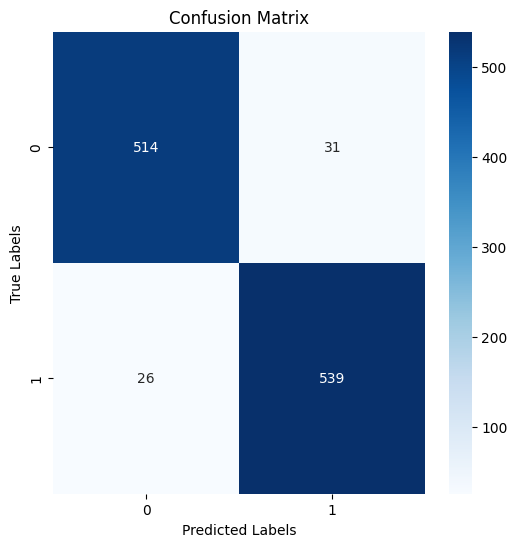

-----


In [13]:
# Optionally load best checkpoint
if os.path.exists(checkpoint_filepath):
    model.load_weights(checkpoint_filepath)

# Evaluate the model
val_preds = model.predict(val_ds).logits
y_pred = np.argmax(val_preds, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print("||-------------------------------------------------------||")
print(f"||--> Run {run_name} evaluation metrics output:")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")
print("||-------------------------------------------------------||")

# # Log metrics to MLflow
# mlflow.log_metrics({
#     "val_accuracy": acc,
#     "val_precision": prec,
#     "val_recall": rec,
#     "val_f1_score": f1
# })

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print("-----")


In [14]:
text_samples = val_df['text'].tolist()

In [15]:
# text_samples = [x for x, y in val_ds]

import pandas as pd
df_results = pd.DataFrame({
    "text": text_samples,
    "true_label": y_true,
    "predicted_label": y_pred
})

In [16]:
# Filter quadrants in the confusion matrix
true_positives = df_results[(df_results["true_label"] == 1) & (df_results["predicted_label"] == 1)]
false_positives = df_results[(df_results["true_label"] == 0) & (df_results["predicted_label"] == 1)]
true_negatives = df_results[(df_results["true_label"] == 0) & (df_results["predicted_label"] == 0)]
false_negatives = df_results[(df_results["true_label"] == 1) & (df_results["predicted_label"] == 0)]

print("False Positives (Ham misclassified as Scam):")
print(false_positives["text"])

print("False Negatives (Scam misclassified as Ham):")
print(false_negatives["text"].head())

False Positives (Ham misclassified as Scam):
71      Want 100% cashback? Download, upgrade in Maya,...
73      Click http://welfare888.world download and hav...
258     05xxxxxx96, Maging maingat! Huwag mag-click ng...
292     Your dream car is within reach when you apply ...
303     You have received P200.00 GCash from E Link Bu...
327     Sorry, hindi sapat ang iyong points para ma-re...
329     Get the most of your device with Google One! T...
338     Never miss a payment deadline when you pay you...
347     Feel the Holiday spirit MORE with 8% CODA Rewa...
374     SMART's Exclusive offer in partnership with Ma...
415     Get up to P8888 cashback when you pay later w/...
427     Awesome! Here's your FREE 2 GB for 3 days!\n\n...
465     You have received P200.00 GCash from E Link Bu...
485     Win a Toyota Land Cruiser ZX with Smart Holide...
518     GCash continues to protect your account. GCash...
535     Make every GigaPoint count! Enjoy a Smart App ...
551     Smart brings you Ho

In [19]:
inter = 0
while inter < 20 and inter < len(false_negatives["text"]):
    print(false_positives["text"].iloc[inter])
    print("----")
    inter+=1

Want 100% cashback? Download, upgrade in Maya, & buy P100 SMART load for yourself now: https://smrt.ph/MayaSignUp

T&Cs apply. Users who qualify for the promo will receive their reward within 3 business days. DTI:FTEB-192508 SO2024  
----
Click http://welfare888.world download and have a chance to get up to 888P for free!
----
05xxxxxx96, Maging maingat! Huwag mag-click ng mga link. HINDI NA MAGPAPADALA ng advisory na may links ang SSS. Para sa updates, bisitahin ang MYSSSPH FB Page.
----
Your dream car is within reach when you apply for a UnionBank Auto Loan! To know more about the latest Auto Loan Deals, you may visit the UnionBank website or e-mail us at vehiclefinance@unionbankph.com.
----
You have received P200.00 GCash from E Link Business Innovation Corporation_Gifted PH FDS w/ MSG - . Your new balance is P221.36 03-08-24 01:52 PM. Ref no. 4015812511987.
----
Sorry, hindi sapat ang iyong points para ma-redeem ang reward. Para sa iba pang offers at list of partner stores kung saa